In [1]:
import scanpy as sc
import scipy
from scipy.sparse import issparse
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import gc
import psutil
from typing import Optional, Tuple, Dict, Any
import logging

# configre logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [2]:
# Memory management utilities
def check_memory_usage():
    """Check current memory usage"""
    process = psutil.Process()
    memory_info = process.memory_info()
    memory_gb = memory_info.rss / (1024 ** 3)
    logger.info(f"Current memory usage: {memory_gb:.2f} GB")
    return memory_gb

def optimize_memory(adata):
    """Optimize memory usage for large datasets"""
    # Convert to sparse if dense
    if not hasattr(adata.X, 'toarray'):
        adata.X = scipy.sparse.csr_matrix(adata.X)
    
    # Optimize dtypes
    for col in adata.obs.columns:
        if adata.obs[col].dtype == 'object':
            adata.obs[col] = adata.obs[col].astype('category')
    
    # Force garbage collection
    gc.collect()
    return adata

## Remove ambient RNA using cellbender (before aggregating the male and female samples)

In [ ]:
female_input = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/pool1_4_female/cell_ranger_outs/multi/count/raw_feature_bc_matrix.h5'
male_input = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/pool5_8_male/cell_ranger_outs/multi/count/raw_feature_bc_matrix.h5'

#### Loading outs into adata for the first time

In [10]:
aggr_csv_path = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/cellranger_aggr/aggregation.csv' 
aggr_df = pd.read_csv(aggr_csv_path)
suffix_to_sample_map = {
    str(i + 1): sample_name
    for i, sample_name in enumerate(aggr_df['sample_id'])
}
logger.info("Created mapping from barcode suffix to sample ID:")
print(suffix_to_sample_map)

matrix_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/cellranger_aggr/count/filtered_gene_bc_matrix"
# Load the full matrix
adata = sc.read_10x_mtx(
    matrix_dir,
    var_names='gene_symbols',
    cache=True,
    gex_only=True
)

# Extract the numeric suffix from each barcode (e.g., '1', '2', '8')
barcode_suffixes = adata.obs.index.str.split('-').str[-1]
# Use the .map() function to apply our dictionary to the suffixes
adata.obs['sample_id'] = barcode_suffixes.map(suffix_to_sample_map)
# get the condition before the underscore in the sample_id
adata.obs['condition'] = adata.obs['sample_id'].str.split('_').str[0]
# get the sex as the first letter after underscore in the sample_id (remove the number)
adata.obs['sex'] = adata.obs['sample_id'].str.split('_').str[1].str[0]

INFO:__main__:Created mapping from barcode suffix to sample ID:


{'1': 'KO_F785', '2': 'KO_F706', '3': 'WT_F3', '4': 'WT_F4', '5': 'KO_M764', '6': 'WT_M2', '7': 'KO_M784', '8': 'WT_M6'}


In [2]:
adata.obs['sample_id'] = adata.obs['sample_id'].str.split('_').str[1] + '_' + adata.obs['sample_id'].str.split('_').str[0]

# Sample specific QC cells and genes (as there are two separate batches)

In [4]:
# Calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var['ribo'] = adata.var_names.str.startswith(('rps', 'rpl'))
adata.var["hb"] = adata.var_names.str.contains("^hb[^(p)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 65106 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [5]:
adata.obs['total_counts_mt']

AAACCCGCAATCGTGG-1     29.0
AAACCCGCAATTAGGC-1     30.0
AAACCCGCACTAGGCA-1    106.0
AAACCCGCAGCCATCT-1     45.0
AAACGGACAAATCGTA-1     69.0
                      ...  
TGTGCCCTCCACCTGC-8     61.0
TGTGCCCTCCTCTCTC-8     38.0
TGTGCCCTCGTCTCGC-8     20.0
TGTGCCCTCTAACCTC-8      7.0
TGTGCCCTCTAAGTCG-8     16.0
Name: total_counts_mt, Length: 65106, dtype: float32

In [6]:
# find the total counts of the cells per sample
display(adata.obs['total_counts'].groupby(adata.obs['sample_id']).sum())
# find the total counts of the cells per condition
display(adata.obs['total_counts'].groupby(adata.obs['condition']).sum())
# find the total counts of the cells per sex
display(adata.obs['total_counts'].groupby(adata.obs['sex']).sum())

sample_id
F3_WT      23813824.0
F4_WT      23210428.0
F706_KO    26614592.0
F785_KO    15184107.0
M2_WT       9299179.0
M6_WT      15423842.0
M764_KO    14190527.0
M784_KO    19447942.0
Name: total_counts, dtype: float32

condition
KO    75437168.0
WT    71747272.0
Name: total_counts, dtype: float32

sex
F    88822952.0
M    58361488.0
Name: total_counts, dtype: float32

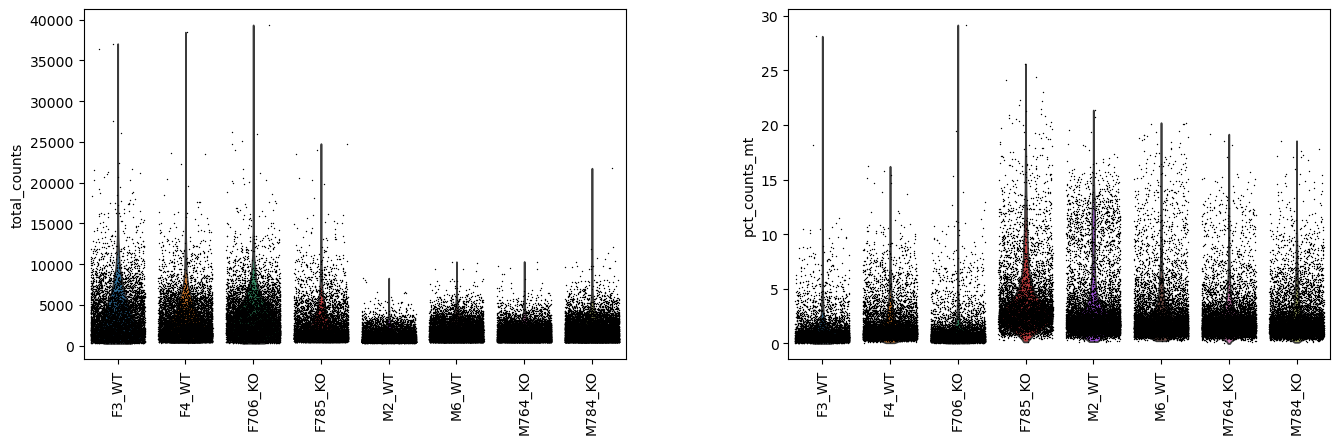

In [4]:
sc.pl.violin(
    adata,
    ["total_counts", "pct_counts_mt"],
    groupby='sample_id',
    jitter=0.4,
    multi_panel=True,
    rotation=90
)

In [5]:
def is_outlier(adata, metric: str, nmads: int):
    from scipy.stats import median_abs_deviation
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [6]:
# Initialize the outlier column to False
adata.obs["outlier"] = False

for sample in adata.obs["sample_id"].unique():
    idx = adata.obs["sample_id"] == sample
    # Subset adata for this sample
    adata_sample = adata[idx]
    # Calculate outliers for this sample only
    outlier_mask = (
        is_outlier(adata_sample, "log1p_total_counts", 5)
        | is_outlier(adata_sample, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata_sample, "pct_counts_in_top_20_genes", 5)
    )
    # Assign back to the main adata.obs
    adata.obs.loc[idx, "outlier"] = outlier_mask.values

In [7]:
adata.obs.groupby("sample_id").outlier.value_counts()

/tmp/ipykernel_74295/2510237385.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("sample_id").outlier.value_counts()


sample_id  outlier
F3_WT      False      6519
           True        113
F4_WT      False      7587
           True         68
F706_KO    False      7511
           True        115
F785_KO    False      6324
           True         39
M2_WT      False      8368
           True         24
M6_WT      False      8796
           True         95
M764_KO    False      9390
           True         73
M784_KO    False      9962
           True        122
Name: count, dtype: int64

In [8]:
adata.obs["mt_outlier"] = (
    adata.obs["pct_counts_mt"] > 10
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    63570
True      1536
Name: count, dtype: int64

In [9]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 65106
Number of cells after filtering of low quality cells: 62960


### Load already created adata

In [3]:
# load updated adata
adata = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/cellranger_aggr/ERCC1_KO_mice_aggr_updated.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 62960 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'sample_id_colors', 'scrublet'
    layers: 'counts'

In [12]:
#sum all true value sin the boolean obs predicted_doublet_score
adata.obs['predicted_doublet'].sum()


2

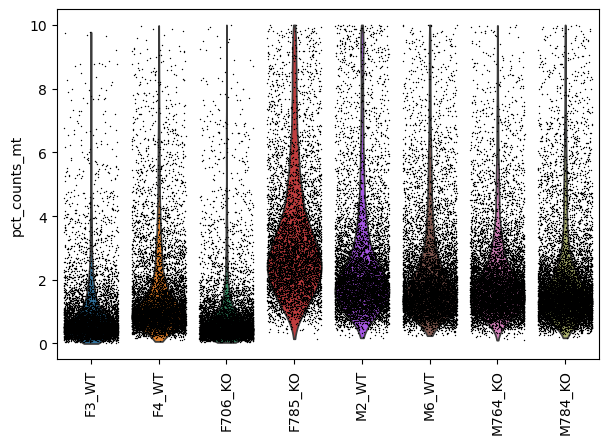

In [4]:
sc.pl.violin(
    adata,
    ["pct_counts_mt"],
    groupby='sample_id',
    jitter=0.4,
    multi_panel=True,
    rotation=90
)

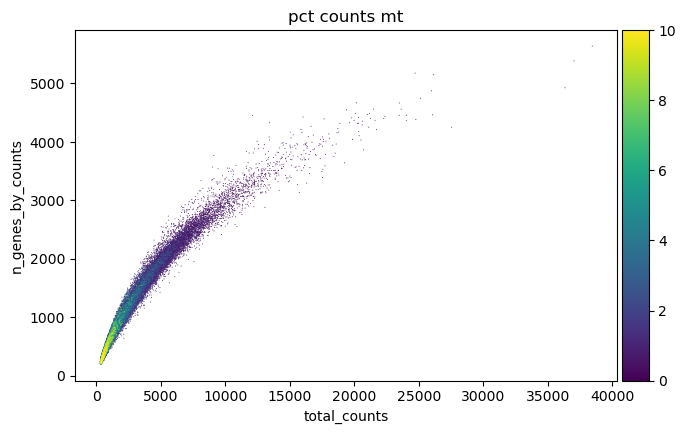

In [5]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [18]:
sc.pp.scrublet(adata, batch_key="sample_id")

In [19]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

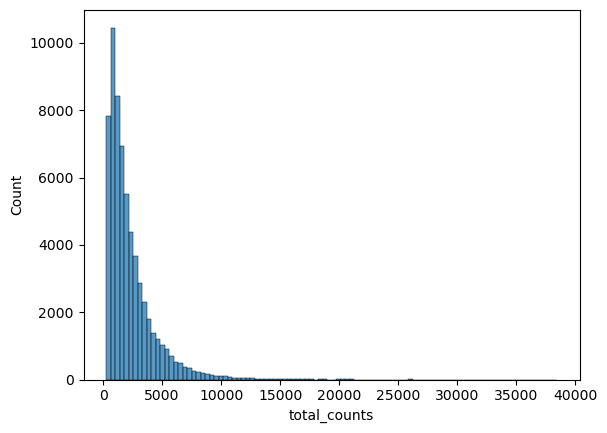

In [21]:
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

## Normalizing the count matrix for downstream processing

In [ ]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

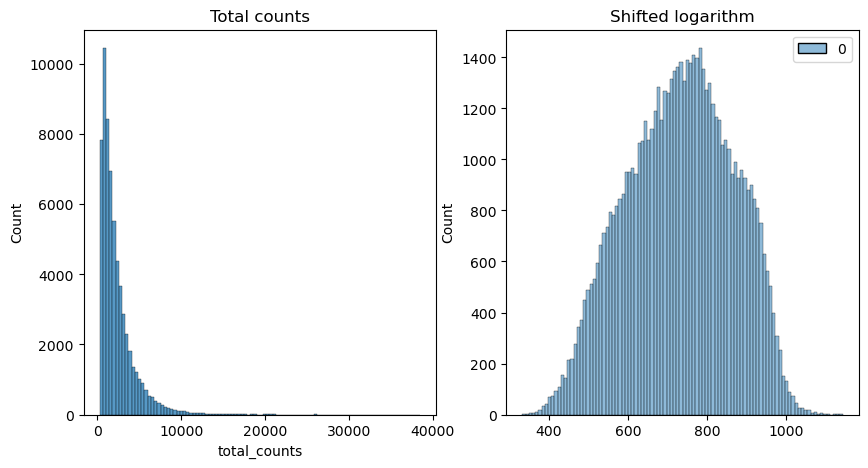

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.X.sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [24]:
# save updated adata
adata.write_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/cellranger_aggr/ERCC1_KO_mice_aggr_updated.h5ad')

... storing 'sample_id' as categorical
... storing 'condition' as categorical
... storing 'sex' as categorical


## Data integration

In [15]:
# load ref adata
adata_ref = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/aging_all_2024/objects/major_celltype_updated_ref.h5ad')
adata_query = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/cellranger_aggr/ERCC1_KO_mice_aggr_updated.h5ad')
# Fix Seurat-to-scanpy compatibility
# adata_ref.uns['pca']['params'] = {
#     'zero_center': True,
#     'use_highly_variable': True,
#     'n_comps': adata_ref.obsm['X_pca'].shape[1]
# }
# sc.pp.neighbors(adata_ref, n_neighbors=10, n_pcs=40)

In [16]:
adata_ref

AnnData object with n_obs × n_vars = 40106 × 20513
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition'
    var: 'highly_variable'
    uns: 'harmony', 'neighbors', 'pca'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs', 'harmony'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'nn', 'snn'

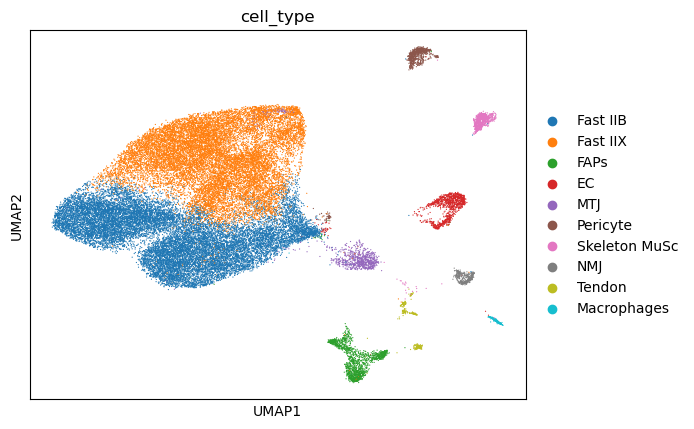

In [17]:
sc.pl.umap(adata_ref, color=['cell_type'])

In [18]:
adata_query

AnnData object with n_obs × n_vars = 62960 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'sample_id_colors', 'scrublet'
    layers: 'counts'

In [19]:
# Subset to common genes (99% overlap)
common_genes = adata_ref.var_names.intersection(adata_query.var_names)
adata_ref_subset = adata_ref[:, common_genes].copy()
adata_query_subset = adata_query[:, common_genes].copy()

In [20]:
# Step 4: Add batch information
adata_ref_subset.obs['batch'] = 'reference'
adata_ref_subset.obs['dataset'] = 'ref'
adata_query_subset.obs['batch'] = 'query'
adata_query_subset.obs['dataset'] = 'query'

In [21]:
# Ensure both have cell_type column
if 'cell_type' not in adata_query_subset.obs.columns:
    adata_query_subset.obs['cell_type'] = 'unknown'

In [22]:
# Step 5: Combine datasets
adata_combined = ad.concat([adata_ref_subset, adata_query_subset], 
                            join='outer', index_unique='-')
print(f"Combined: {adata_combined.n_obs} cells × {adata_combined.n_vars} genes")

Combined: 103066 cells × 20500 genes


In [23]:
adata_combined

AnnData object with n_obs × n_vars = 103066 × 20500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'batch', 'dataset', 'sample_id', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [24]:
# Step 6: Preprocessing (counts norma nd feature selection)
print("\n6. Preprocessing combined dataset...")

# Use raw counts if available
if 'counts' in adata_combined.layers:
    adata_combined.X = adata_combined.layers['counts'].copy()

# Normalize and log transform
sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)
adata_combined.raw = adata_combined

# Find highly variable genes (batch-aware)
sc.pp.highly_variable_genes(adata_combined, 
                            min_mean=0.0125, max_mean=3, min_disp=0.5,
                            batch_key='batch')

# Filter to HVGs
adata_combined = adata_combined[:, adata_combined.var.highly_variable]
print(f"Highly variable genes: {adata_combined.n_vars}")

# Scale data
sc.pp.scale(adata_combined, max_value=10)


6. Preprocessing combined dataset...


... storing 'cell_type' as categorical
... storing 'batch' as categorical
... storing 'dataset' as categorical


Highly variable genes: 2785


/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [25]:
# Step 7: PCA
print("\n7. Computing PCA...")
sc.tl.pca(adata_combined, svd_solver='arpack', n_comps=50)


7. Computing PCA...


In [26]:
# Step 8: Harmony integration
print("\n8. Running Harmony integration...")
try:
    import harmonypy as hm
    harmony_out = hm.run_harmony(adata_combined.obsm['X_pca'], 
                                adata_combined.obs, 
                                vars_use=['batch'])
    adata_combined.obsm['X_harmony'] = harmony_out.Z_corr.T
    use_rep = 'X_harmony'
    print("Harmony integration completed!")
except ImportError:
    print("Harmony not available, using PCA for downstream analysis")
    use_rep = 'X_pca'


8. Running Harmony integration...


2025-08-08 08:22:30,884 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-08-08 08:22:41,861 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-08-08 08:22:42,196 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-08-08 08:23:02,077 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-08-08 08:23:21,798 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-08-08 08:23:42,363 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-08-08 08:23:56,663 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-08-08 08:24:04,720 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-08-08 08:24:11,915 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-08-08 08:24:18,129 - 

Harmony integration completed!


In [27]:
adata_combined

AnnData object with n_obs × n_vars = 103066 × 2785
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'batch', 'dataset', 'sample_id', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [28]:
# Step 9: Downstream analysis
print("\n9. Downstream analysis...")
sc.pp.neighbors(adata_combined, use_rep=use_rep, n_neighbors=15)
sc.tl.umap(adata_combined)
sc.tl.leiden(adata_combined, resolution=0.5)


9. Downstream analysis...


/tmp/ipykernel_23359/3591004641.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined, resolution=0.5)



10. Creating visualizations...


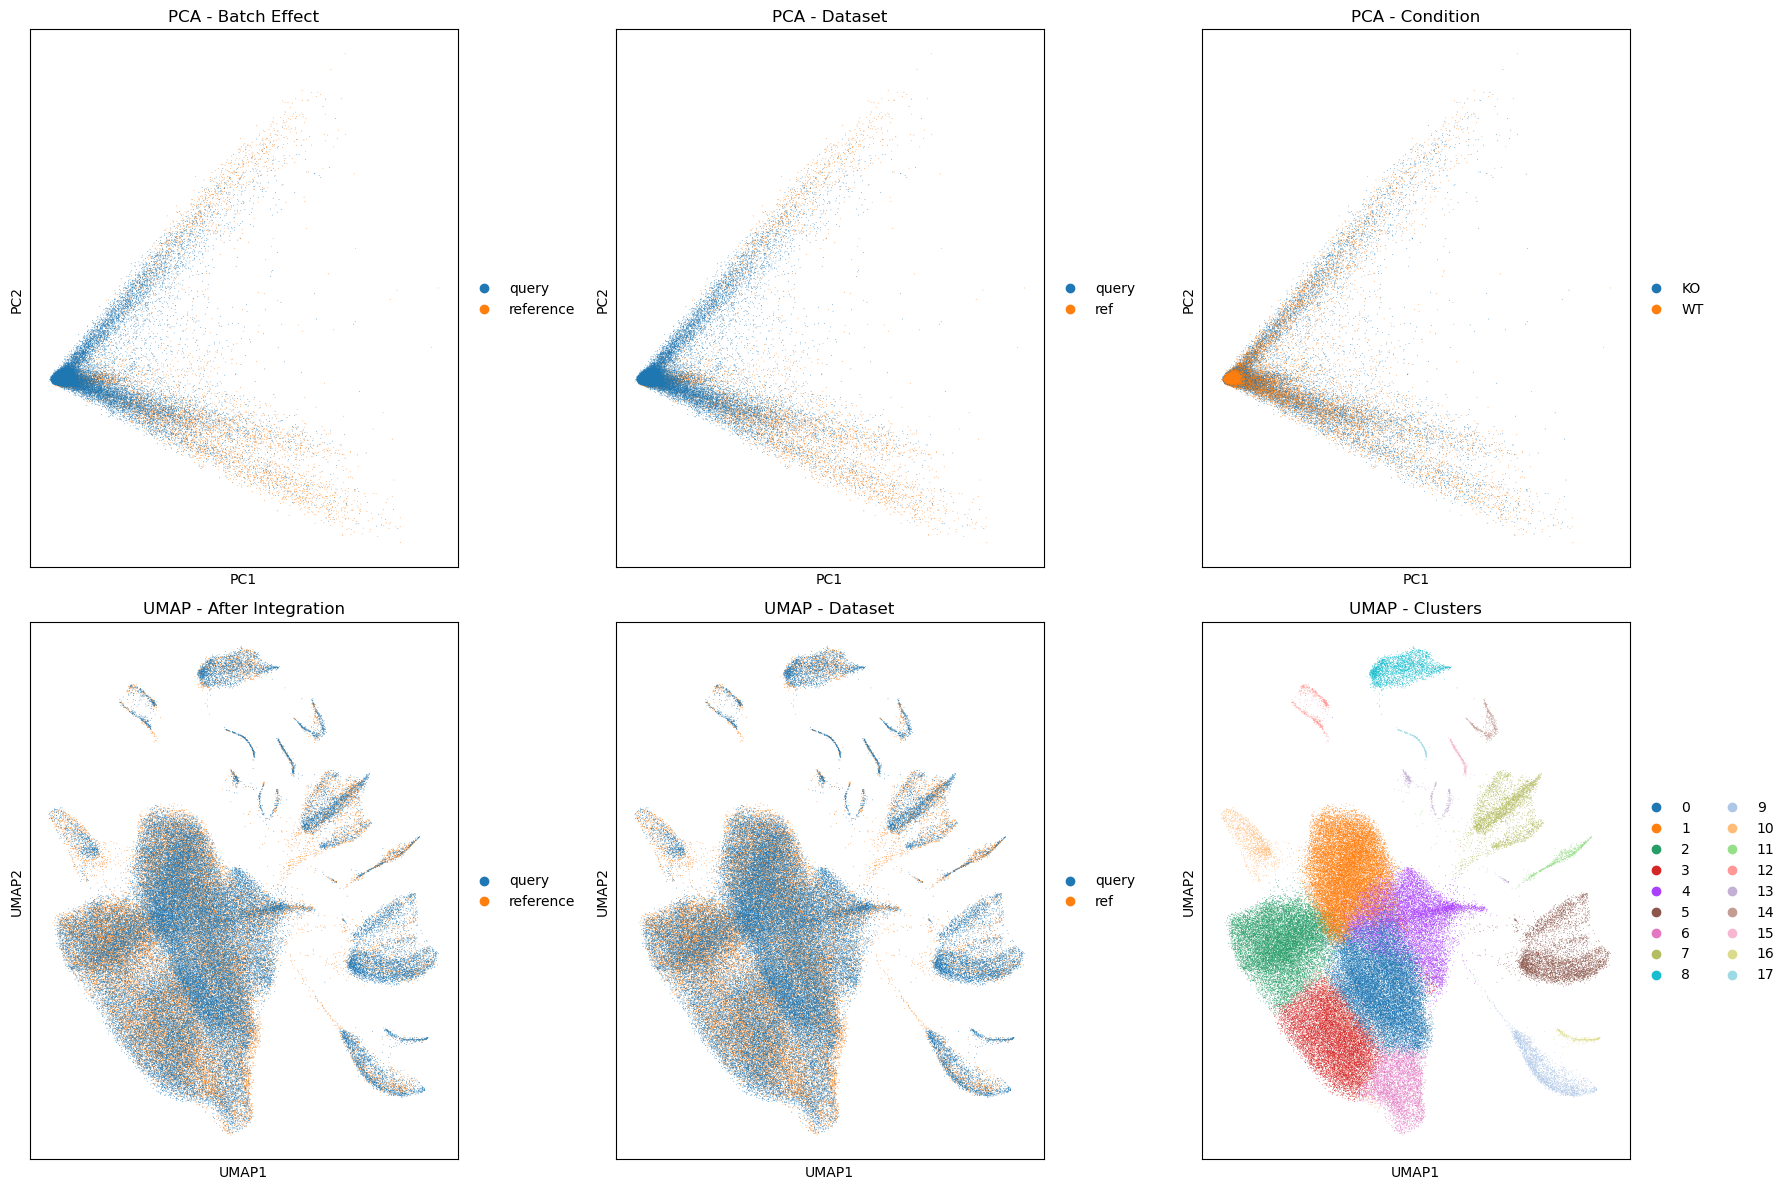

In [31]:
# Step 10: Visualization
print("\n10. Creating visualizations...")

# Plot integration results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Before integration
sc.pl.pca(adata_combined, color='batch', ax=axes[0,0], show=False)
axes[0,0].set_title('PCA - Batch Effect')

sc.pl.pca(adata_combined, color='dataset', ax=axes[0,1], show=False)
axes[0,1].set_title('PCA - Dataset')

if 'condition' in adata_combined.obs.columns:
    sc.pl.pca(adata_combined, color='condition', ax=axes[0,2], show=False)
    axes[0,2].set_title('PCA - Condition')
else:
    axes[0,2].axis('off')

# After integration
sc.pl.umap(adata_combined, color='batch', ax=axes[1,0], show=False)
axes[1,0].set_title('UMAP - After Integration')

sc.pl.umap(adata_combined, color='dataset', ax=axes[1,1], show=False)
axes[1,1].set_title('UMAP - Dataset')

sc.pl.umap(adata_combined, color='leiden', ax=axes[1,2], show=False)
axes[1,2].set_title('UMAP - Clusters')

plt.tight_layout()
plt.show()

In [32]:
# Step 11: Quality assessment
print("\n11. Integration quality assessment...")

# Batch mixing in clusters
mixing_df = pd.crosstab(adata_combined.obs['leiden'], adata_combined.obs['batch'])
print("\nBatch mixing in clusters:")
print(mixing_df)

# Save results
output_dir = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_12_samples'
adata_combined.write(f'{output_dir}/integrated_dataset.h5ad')
mixing_df.to_csv(f'{output_dir}/batch_mixing_analysis.csv')

print(f"\nIntegration completed! Files saved to {output_dir}")


11. Integration quality assessment...

Batch mixing in clusters:
batch   query  reference
leiden                  
0       12680       7310
1       12527       7427
2        7730       7682
3        6999       5863
4        8466       3707
5        4045       1031
6        2332       2251
7        2003       1552
8        1817        750
9        1568        726
10        963        748
11        265        377
12        343        193
13        290        192
14        294        143
15        226         63
16        243         43
17        169         48

Integration completed! Files saved to /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_12_samples


In [33]:
adata_combined

AnnData object with n_obs × n_vars = 103066 × 2785
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'batch', 'dataset', 'sample_id', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'batch_colors', 'dataset_colors', 'condition_colors', 'leiden_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'di

<Axes: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

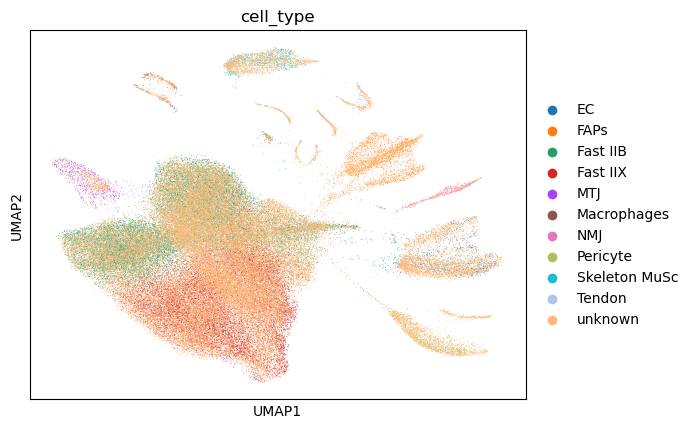

In [37]:
sc.pl.umap(adata_combined, color='cell_type', show=False)